In [ ]:
import kagglehub
requiemonk_sentinel12_image_pairs_segregated_by_terrain_path = kagglehub.dataset_download('requiemonk/sentinel12-image-pairs-segregated-by-terrain')

print('Data source import complete.')

Data source import complete.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split

from PIL import Image
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

!pip install torchmetrics
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity



device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split

from PIL import Image
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity



device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

class SentinelDataset(Dataset):
    def __init__(self, root_dir, image_size=128, mode='train', split_ratio=0.8):
        self.root_dir = root_dir
        self.image_pairs = []

        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

        def get_base_name(fname):
            return re.sub(r'_s[12]_', '_', fname)
        terrains = ['agri']
        print(f"Loading data for {mode} set from folder: {terrains[0]}")

        for terrain in terrains:
            terrain_path = os.path.join(root_dir, terrain)
            if not os.path.isdir(terrain_path):
                print(f"Warning: Folder '{terrain}' not found. Skipping.")
                continue

            s1_path = os.path.join(terrain_path, "s1")
            s2_path = os.path.join(terrain_path, "s2")

            if os.path.isdir(s1_path) and os.path.isdir(s2_path):
                s1_files = {get_base_name(f): os.path.join(s1_path, f) for f in os.listdir(s1_path) if f.endswith(".png")}
                s2_files = {get_base_name(f): os.path.join(s2_path, f) for f in os.listdir(s2_path) if f.endswith(".png")}

                common_base_names = sorted(list(s1_files.keys() & s2_files.keys()))

                # Split the data into training and validation sets
                train_base_names, val_base_names = train_test_split(common_base_names, train_size=split_ratio, random_state=42)

                if mode == 'train':
                    selected_base_names = train_base_names
                else:
                    selected_base_names = val_base_names

                for base_name in selected_base_names:
                    self.image_pairs.append((s1_files[base_name], s2_files[base_name]))

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, idx):
        s1_path, s2_path = self.image_pairs[idx]
        condition_img = Image.open(s1_path).convert("RGB")
        target_img = Image.open(s2_path).convert("RGB")
        condition_img = self.transform(condition_img)
        target_img = self.transform(target_img)
        return condition_img, target_img

Using device: cuda


In [ ]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect")
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x

class Generator128(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        self.down1 = Block(features, features * 2, down=True, act="leaky")
        self.down2 = Block(features * 2, features * 4, down=True, act="leaky")
        self.down3 = Block(features * 4, features * 8, down=True, act="leaky")
        self.down4 = Block(features * 8, features * 8, down=True, act="leaky")
        self.down5 = Block(features * 8, features * 8, down=True, act="leaky")
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features * 8, features * 8, 4, 2, 1), nn.ReLU()
        )
        self.up1 = Block(features * 8, features * 8, down=False, act="relu", use_dropout=True)
        self.up3 = Block(features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True)
        self.up4 = Block(features * 8 * 2, features * 4, down=False, act="relu")
        self.up5 = Block(features * 4 + features * 8, features * 2, down=False, act="relu")
        self.up6 = Block(features * 2 + features * 4, features, down=False, act="relu")
        self.up7 = Block(features + features * 2, features, down=False, act="relu")
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features * 2, in_channels, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        bottleneck = self.bottleneck(d6)
        up1 = self.up1(bottleneck)
        up3 = self.up3(torch.cat([up1, d6], 1))
        up4 = self.up4(torch.cat([up3, d5], 1))
        up5 = self.up5(torch.cat([up4, d4], 1))
        up6 = self.up6(torch.cat([up5, d3], 1))
        up7 = self.up7(torch.cat([up6, d2], 1))
        return self.final_up(torch.cat([up7, d1], 1))

In [ ]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride, bias=False, padding_mode="reflect"),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )
    def forward(self, x):
        return self.conv(x)

class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels * 2, features[0], kernel_size=4, stride=2, padding=1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(CNNBlock(in_channels, feature, stride=1 if feature == features[-1] else 2))
            in_channels = feature
        layers.append(nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"))
        self.model = nn.Sequential(*layers)

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        x = self.initial(x)
        return self.model(x)

In [ ]:
LEARNING_RATE = 2e-4
BATCH_SIZE = 16
NUM_WORKERS = 4
IMAGE_SIZE = 128
CHANNELS_IMG = 3
L1_LAMBDA = 100
NUM_EPOCHS = 150

DATASET_PATH = "/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/"
os.makedirs("saved_images", exist_ok=True)

disc = Discriminator(in_channels=CHANNELS_IMG).to(device)
gen = Generator128(in_channels=CHANNELS_IMG).to(device)
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

BCE = nn.BCEWithLogitsLoss()
L1_LOSS = nn.L1Loss()

# Create the training dataset and dataloader
train_dataset = SentinelDataset(
    root_dir=DATASET_PATH,
    image_size=IMAGE_SIZE,
    mode='train'
)
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

# Create the validation dataset and dataloader
val_dataset = SentinelDataset(
    root_dir=DATASET_PATH,
    image_size=IMAGE_SIZE,
    mode='val'
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"Found {len(train_dataset)} image pairs for training.")
print(f"Found {len(val_dataset)} image pairs for validation.")

Loading data for train set from folder: agri
Loading data for val set from folder: agri
Found 3200 image pairs for training.
Found 800 image pairs for validation.


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
def train_fn(disc, gen, loader, opt_disc, opt_gen, l1_loss, bce):
    loop = tqdm(loader, leave=True)

    avg_disc_loss = 0.0
    avg_gen_loss = 0.0

    for idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)

        # Train Discriminator
        with torch.amp.autocast(device_type=device, dtype=torch.float16):
            y_fake = gen(x)
            D_real = disc(x, y)
            D_real_loss = bce(D_real, torch.ones_like(D_real))
            D_fake = disc(x, y_fake.detach())
            D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
            D_loss = (D_real_loss + D_fake_loss) / 2

        disc.zero_grad()
        D_loss.backward()
        opt_disc.step()

        # Train Generator
        with torch.amp.autocast(device_type=device, dtype=torch.float16):
            D_fake = disc(x, y_fake)
            G_fake_loss = bce(D_fake, torch.ones_like(D_fake))
            L1 = l1_loss(y_fake, y) * L1_LAMBDA
            G_loss = G_fake_loss + L1

        opt_gen.zero_grad()
        G_loss.backward()
        opt_gen.step()

        avg_disc_loss += D_loss.item()
        avg_gen_loss += G_loss.item()

        if idx % 10 == 0:
            loop.set_postfix(
                D_real=torch.sigmoid(D_real).mean().item(),
                D_fake=torch.sigmoid(D_fake).mean().item(),
            )

    return avg_disc_loss / len(loader), avg_gen_loss / len(loader)


def validate_fn(disc, gen, loader, l1_loss, bce):
    loop = tqdm(loader, leave=True, desc="Validating")

    avg_disc_loss_val = 0.0
    avg_gen_loss_val = 0.0

    gen.eval()
    disc.eval()

    with torch.no_grad():
        for x, y in loop:
            x, y = x.to(device), y.to(device)

            with torch.amp.autocast(device_type=device, dtype=torch.float16):
                y_fake = gen(x)

                # Discriminator Loss
                D_real = disc(x, y)
                D_real_loss = bce(D_real, torch.ones_like(D_real))
                D_fake = disc(x, y_fake.detach())
                D_fake_loss = bce(D_fake, torch.zeros_like(D_fake))
                D_loss = (D_real_loss + D_fake_loss) / 2

                # Generator Loss
                D_fake_g = disc(x, y_fake)
                G_fake_loss = bce(D_fake_g, torch.ones_like(D_fake_g))
                L1 = l1_loss(y_fake, y) * L1_LAMBDA
                G_loss = G_fake_loss + L1

            avg_disc_loss_val += D_loss.item()
            avg_gen_loss_val += G_loss.item()

    gen.train()
    disc.train()

    return avg_disc_loss_val / len(loader), avg_gen_loss_val / len(loader)

def save_example_images(gen, val_loader, epoch, folder="saved_images"):
    x, y = next(iter(val_loader))
    x, y = x.to(device), y.to(device)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        y_fake = y_fake * 0.5 + 0.5
        x = x * 0.5 + 0.5
        y = y * 0.5 + 0.5
        save_image(x, folder + f"/input_{epoch}.png")
        save_image(y, folder + f"/label_{epoch}.png")
        save_image(y_fake, folder + f"/fake_{epoch}.png")
    gen.train()

In [ ]:
NUM_EPOCHS = 150

d_loss_history = []
g_loss_history = []
d_loss_val_history = []
g_loss_val_history = []

for epoch in range(NUM_EPOCHS):
    print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")

    avg_d_loss, avg_g_loss = train_fn(disc, gen, train_loader, opt_disc, opt_gen, L1_LOSS, BCE)
    d_loss_history.append(avg_d_loss)
    g_loss_history.append(avg_g_loss)

    avg_d_loss_val, avg_g_loss_val = validate_fn(disc, gen, val_loader, L1_LOSS, BCE)
    d_loss_val_history.append(avg_d_loss_val)
    g_loss_val_history.append(avg_g_loss_val)

    print(f"Train D Loss: {avg_d_loss:.4f}, Train G Loss: {avg_g_loss:.4f}")
    print(f"Val D Loss: {avg_d_loss_val:.4f}, Val G Loss: {avg_g_loss_val:.4f}")

    if (epoch + 1) % 5 == 0:
        print("📸 Saving example images...")
        try:
            save_example_images(gen, val_loader, epoch + 1, folder="saved_images")
        except StopIteration:
            print("Validation loader is empty. Cannot save examples.")


--- Epoch 1/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.4647, Train G Loss: 34.7174
Val D Loss: 1.4149, Val G Loss: 33.6644

--- Epoch 2/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.1285, Train G Loss: 33.3735
Val D Loss: 1.7130, Val G Loss: 33.3104

--- Epoch 3/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3594, Train G Loss: 33.2166
Val D Loss: 0.7498, Val G Loss: 31.8241

--- Epoch 4/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.1712, Train G Loss: 33.4538
Val D Loss: 1.6813, Val G Loss: 31.6796

--- Epoch 5/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.0209, Train G Loss: 33.5747
Val D Loss: 1.4356, Val G Loss: 32.3702
📸 Saving example images...

--- Epoch 6/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.0441, Train G Loss: 33.6949
Val D Loss: 2.3160, Val G Loss: 37.5947

--- Epoch 7/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.1864, Train G Loss: 33.3916
Val D Loss: 1.9285, Val G Loss: 34.5442

--- Epoch 8/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.0306, Train G Loss: 32.6518
Val D Loss: 1.4960, Val G Loss: 29.9390

--- Epoch 9/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.1231, Train G Loss: 32.6246
Val D Loss: 1.2312, Val G Loss: 29.4142

--- Epoch 10/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.0132, Train G Loss: 32.4804
Val D Loss: 1.0571, Val G Loss: 30.6207
📸 Saving example images...

--- Epoch 11/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.0069, Train G Loss: 32.6165
Val D Loss: 4.7928, Val G Loss: 35.5195

--- Epoch 12/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.0830, Train G Loss: 31.8286
Val D Loss: 1.4289, Val G Loss: 35.6821

--- Epoch 13/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.1713, Train G Loss: 31.9802
Val D Loss: 1.2747, Val G Loss: 29.9465

--- Epoch 14/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.1509, Train G Loss: 31.1655
Val D Loss: 3.1700, Val G Loss: 35.0961

--- Epoch 15/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2718, Train G Loss: 30.5342
Val D Loss: 0.8868, Val G Loss: 34.3368
📸 Saving example images...

--- Epoch 16/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2278, Train G Loss: 30.5924
Val D Loss: 1.6757, Val G Loss: 32.8397

--- Epoch 17/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2695, Train G Loss: 30.1171
Val D Loss: 1.3150, Val G Loss: 28.7286

--- Epoch 18/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3212, Train G Loss: 29.1402
Val D Loss: 1.0203, Val G Loss: 30.0899

--- Epoch 19/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2573, Train G Loss: 29.3093
Val D Loss: 0.9246, Val G Loss: 29.4085

--- Epoch 20/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2788, Train G Loss: 28.6879
Val D Loss: 0.5843, Val G Loss: 29.1227
📸 Saving example images...

--- Epoch 21/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2388, Train G Loss: 28.4510
Val D Loss: 0.8661, Val G Loss: 26.4079

--- Epoch 22/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2799, Train G Loss: 27.7411
Val D Loss: 0.7663, Val G Loss: 29.8462

--- Epoch 23/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2096, Train G Loss: 27.5731
Val D Loss: 1.1825, Val G Loss: 26.2593

--- Epoch 24/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2404, Train G Loss: 26.8310
Val D Loss: 1.3263, Val G Loss: 26.5025

--- Epoch 25/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.1922, Train G Loss: 26.9350
Val D Loss: 1.0875, Val G Loss: 27.0466
📸 Saving example images...

--- Epoch 26/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.1945, Train G Loss: 26.5790
Val D Loss: 1.0158, Val G Loss: 26.9624

--- Epoch 27/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.1898, Train G Loss: 26.6082
Val D Loss: 1.1864, Val G Loss: 25.8231

--- Epoch 28/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2256, Train G Loss: 25.8007
Val D Loss: 1.0049, Val G Loss: 27.7446

--- Epoch 29/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2021, Train G Loss: 25.5628
Val D Loss: 1.2684, Val G Loss: 26.7229

--- Epoch 30/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2599, Train G Loss: 24.8454
Val D Loss: 1.2247, Val G Loss: 28.0670
📸 Saving example images...

--- Epoch 31/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2410, Train G Loss: 24.8652
Val D Loss: 0.9998, Val G Loss: 24.5691

--- Epoch 32/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.1906, Train G Loss: 24.8523
Val D Loss: 0.9148, Val G Loss: 25.8181

--- Epoch 33/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3595, Train G Loss: 23.5126
Val D Loss: 0.8170, Val G Loss: 22.4566

--- Epoch 34/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2269, Train G Loss: 23.5524
Val D Loss: 1.0075, Val G Loss: 23.9827

--- Epoch 35/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2499, Train G Loss: 23.2678
Val D Loss: 0.7041, Val G Loss: 23.2713
📸 Saving example images...

--- Epoch 36/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2624, Train G Loss: 23.0412
Val D Loss: 0.6274, Val G Loss: 24.2583

--- Epoch 37/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2782, Train G Loss: 22.8283
Val D Loss: 1.2628, Val G Loss: 25.1049

--- Epoch 38/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2638, Train G Loss: 22.6780
Val D Loss: 0.8639, Val G Loss: 21.9969

--- Epoch 39/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2612, Train G Loss: 22.4023
Val D Loss: 0.9504, Val G Loss: 22.7595

--- Epoch 40/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2466, Train G Loss: 22.4253
Val D Loss: 0.7508, Val G Loss: 22.0221
📸 Saving example images...

--- Epoch 41/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2665, Train G Loss: 22.2085
Val D Loss: 2.2492, Val G Loss: 22.9283

--- Epoch 42/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3125, Train G Loss: 21.7112
Val D Loss: 0.6523, Val G Loss: 21.7530

--- Epoch 43/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3033, Train G Loss: 21.4203
Val D Loss: 0.8324, Val G Loss: 22.2778

--- Epoch 44/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2252, Train G Loss: 21.5086
Val D Loss: 0.6830, Val G Loss: 22.4260

--- Epoch 45/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2585, Train G Loss: 21.5496
Val D Loss: 0.9090, Val G Loss: 23.3075
📸 Saving example images...

--- Epoch 46/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2866, Train G Loss: 21.4357
Val D Loss: 0.7737, Val G Loss: 22.8455

--- Epoch 47/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2666, Train G Loss: 21.2638
Val D Loss: 0.7693, Val G Loss: 21.3357

--- Epoch 48/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3166, Train G Loss: 20.9215
Val D Loss: 0.8071, Val G Loss: 20.8320

--- Epoch 49/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2204, Train G Loss: 20.8878
Val D Loss: 1.1511, Val G Loss: 25.4916

--- Epoch 50/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2646, Train G Loss: 20.7918
Val D Loss: 0.9599, Val G Loss: 22.0220
📸 Saving example images...

--- Epoch 51/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2964, Train G Loss: 20.4179
Val D Loss: 0.6352, Val G Loss: 23.9664

--- Epoch 52/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2520, Train G Loss: 20.4516
Val D Loss: 0.7890, Val G Loss: 21.1791

--- Epoch 53/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2400, Train G Loss: 20.3943
Val D Loss: 0.9444, Val G Loss: 22.4113

--- Epoch 54/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2420, Train G Loss: 20.6303
Val D Loss: 1.0567, Val G Loss: 20.5736

--- Epoch 55/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2045, Train G Loss: 20.4702
Val D Loss: 0.9370, Val G Loss: 22.4955
📸 Saving example images...

--- Epoch 56/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2306, Train G Loss: 20.3030
Val D Loss: 0.7141, Val G Loss: 21.0230

--- Epoch 57/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2948, Train G Loss: 20.1681
Val D Loss: 0.8486, Val G Loss: 19.9276

--- Epoch 58/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2642, Train G Loss: 19.7705
Val D Loss: 0.7748, Val G Loss: 20.0509

--- Epoch 59/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3431, Train G Loss: 19.9411
Val D Loss: 0.9322, Val G Loss: 18.9988

--- Epoch 60/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2320, Train G Loss: 19.0965
Val D Loss: 0.8679, Val G Loss: 22.5707
📸 Saving example images...

--- Epoch 61/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2551, Train G Loss: 19.8272
Val D Loss: 1.0962, Val G Loss: 19.7687

--- Epoch 62/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2193, Train G Loss: 20.2738
Val D Loss: 0.8745, Val G Loss: 21.8394

--- Epoch 63/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2919, Train G Loss: 19.5867
Val D Loss: 1.2362, Val G Loss: 21.9527

--- Epoch 64/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3307, Train G Loss: 19.1950
Val D Loss: 0.7889, Val G Loss: 19.4538

--- Epoch 65/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2555, Train G Loss: 19.2820
Val D Loss: 0.6467, Val G Loss: 22.0826
📸 Saving example images...

--- Epoch 66/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2744, Train G Loss: 19.2918
Val D Loss: 0.8636, Val G Loss: 21.1541

--- Epoch 67/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3147, Train G Loss: 18.9990
Val D Loss: 1.1235, Val G Loss: 20.5989

--- Epoch 68/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2327, Train G Loss: 19.1831
Val D Loss: 0.8467, Val G Loss: 20.4560

--- Epoch 69/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.4359, Train G Loss: 18.0111
Val D Loss: 0.7001, Val G Loss: 20.1952

--- Epoch 70/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2151, Train G Loss: 18.7990
Val D Loss: 1.1998, Val G Loss: 19.0155
📸 Saving example images...

--- Epoch 71/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2440, Train G Loss: 18.6693
Val D Loss: 0.8495, Val G Loss: 20.4058

--- Epoch 72/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3146, Train G Loss: 18.2159
Val D Loss: 0.5856, Val G Loss: 20.2489

--- Epoch 73/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3487, Train G Loss: 18.3741
Val D Loss: 0.9314, Val G Loss: 20.2063

--- Epoch 74/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2742, Train G Loss: 18.2677
Val D Loss: 0.6903, Val G Loss: 19.9114

--- Epoch 75/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3034, Train G Loss: 18.3292
Val D Loss: 0.8255, Val G Loss: 21.2015
📸 Saving example images...

--- Epoch 76/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2987, Train G Loss: 18.2501
Val D Loss: 1.1472, Val G Loss: 20.6479

--- Epoch 77/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2684, Train G Loss: 18.0687
Val D Loss: 0.8793, Val G Loss: 19.7427

--- Epoch 78/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3210, Train G Loss: 17.7606
Val D Loss: 0.8724, Val G Loss: 19.1069

--- Epoch 79/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2394, Train G Loss: 18.0074
Val D Loss: 1.0221, Val G Loss: 20.0606

--- Epoch 80/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3240, Train G Loss: 17.6828
Val D Loss: 0.8866, Val G Loss: 19.4241
📸 Saving example images...

--- Epoch 81/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2878, Train G Loss: 17.8261
Val D Loss: 0.7212, Val G Loss: 19.0230

--- Epoch 82/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3331, Train G Loss: 17.4365
Val D Loss: 0.5817, Val G Loss: 18.3752

--- Epoch 83/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2868, Train G Loss: 17.3633
Val D Loss: 0.7419, Val G Loss: 18.4961

--- Epoch 84/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2790, Train G Loss: 17.3907
Val D Loss: 0.8082, Val G Loss: 19.8612

--- Epoch 85/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3689, Train G Loss: 17.0889
Val D Loss: 0.7462, Val G Loss: 18.5964
📸 Saving example images...

--- Epoch 86/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2966, Train G Loss: 17.1444
Val D Loss: 0.7004, Val G Loss: 18.5472

--- Epoch 87/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3017, Train G Loss: 17.1912
Val D Loss: 0.7385, Val G Loss: 19.6713

--- Epoch 88/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3623, Train G Loss: 16.8083
Val D Loss: 1.0708, Val G Loss: 18.1110

--- Epoch 89/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3171, Train G Loss: 16.7179
Val D Loss: 1.1930, Val G Loss: 20.0635

--- Epoch 90/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3371, Train G Loss: 16.7289
Val D Loss: 0.6547, Val G Loss: 18.6686
📸 Saving example images...

--- Epoch 91/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2862, Train G Loss: 16.9625
Val D Loss: 0.6564, Val G Loss: 19.1570

--- Epoch 92/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3093, Train G Loss: 17.1054
Val D Loss: 0.8461, Val G Loss: 18.7660

--- Epoch 93/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3025, Train G Loss: 16.7556
Val D Loss: 0.7041, Val G Loss: 18.3205

--- Epoch 94/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3696, Train G Loss: 16.4623
Val D Loss: 0.9237, Val G Loss: 18.3374

--- Epoch 95/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3332, Train G Loss: 16.4763
Val D Loss: 1.0634, Val G Loss: 19.1045
📸 Saving example images...

--- Epoch 96/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2457, Train G Loss: 18.5851
Val D Loss: 0.7257, Val G Loss: 21.4688

--- Epoch 97/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2482, Train G Loss: 18.0826
Val D Loss: 2.4152, Val G Loss: 21.2509

--- Epoch 98/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3051, Train G Loss: 16.8837
Val D Loss: 0.8096, Val G Loss: 19.2285

--- Epoch 99/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3772, Train G Loss: 16.3634
Val D Loss: 1.0097, Val G Loss: 18.7796

--- Epoch 100/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3219, Train G Loss: 16.4075
Val D Loss: 0.9093, Val G Loss: 19.1848
📸 Saving example images...

--- Epoch 101/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3073, Train G Loss: 16.4404
Val D Loss: 0.7083, Val G Loss: 18.1554

--- Epoch 102/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3566, Train G Loss: 16.1675
Val D Loss: 0.5541, Val G Loss: 18.1632

--- Epoch 103/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3748, Train G Loss: 15.9235
Val D Loss: 0.7166, Val G Loss: 18.9979

--- Epoch 104/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3712, Train G Loss: 15.9189
Val D Loss: 0.8790, Val G Loss: 18.4550

--- Epoch 105/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3177, Train G Loss: 15.9498
Val D Loss: 0.5474, Val G Loss: 18.7316
📸 Saving example images...

--- Epoch 106/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3118, Train G Loss: 15.8592
Val D Loss: 0.8630, Val G Loss: 18.5018

--- Epoch 107/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3167, Train G Loss: 15.9032
Val D Loss: 0.7166, Val G Loss: 18.0336

--- Epoch 108/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3677, Train G Loss: 15.9028
Val D Loss: 0.8345, Val G Loss: 18.1560

--- Epoch 109/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3562, Train G Loss: 15.6335
Val D Loss: 0.7806, Val G Loss: 18.2793

--- Epoch 110/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3011, Train G Loss: 16.1370
Val D Loss: 0.6532, Val G Loss: 18.5281
📸 Saving example images...

--- Epoch 111/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3809, Train G Loss: 15.7867
Val D Loss: 1.4009, Val G Loss: 18.7256

--- Epoch 112/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3985, Train G Loss: 15.2016
Val D Loss: 0.5579, Val G Loss: 18.8664

--- Epoch 113/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3135, Train G Loss: 15.4828
Val D Loss: 0.8335, Val G Loss: 20.5234

--- Epoch 114/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3577, Train G Loss: 15.3642
Val D Loss: 0.9057, Val G Loss: 18.5778

--- Epoch 115/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3691, Train G Loss: 15.3920
Val D Loss: 0.8042, Val G Loss: 18.5222
📸 Saving example images...

--- Epoch 116/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3072, Train G Loss: 15.7697
Val D Loss: 0.8428, Val G Loss: 18.5300

--- Epoch 117/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3255, Train G Loss: 15.6924
Val D Loss: 0.5583, Val G Loss: 18.2700

--- Epoch 118/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3697, Train G Loss: 15.3944
Val D Loss: 1.0142, Val G Loss: 17.4949

--- Epoch 119/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3653, Train G Loss: 15.2166
Val D Loss: 0.8079, Val G Loss: 18.1014

--- Epoch 120/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.4119, Train G Loss: 14.9221
Val D Loss: 1.3780, Val G Loss: 19.2882
📸 Saving example images...

--- Epoch 121/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3912, Train G Loss: 14.7858
Val D Loss: 0.6975, Val G Loss: 17.0677

--- Epoch 122/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.4345, Train G Loss: 14.5869
Val D Loss: 0.7220, Val G Loss: 17.6644

--- Epoch 123/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.4010, Train G Loss: 14.5995
Val D Loss: 0.7331, Val G Loss: 18.0256

--- Epoch 124/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3825, Train G Loss: 14.7128
Val D Loss: 0.6437, Val G Loss: 17.3853

--- Epoch 125/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.4048, Train G Loss: 14.5896
Val D Loss: 0.7218, Val G Loss: 18.0554
📸 Saving example images...

--- Epoch 126/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3647, Train G Loss: 14.8439
Val D Loss: 0.6903, Val G Loss: 17.7819

--- Epoch 127/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2934, Train G Loss: 15.3233
Val D Loss: 0.5995, Val G Loss: 18.5091

--- Epoch 128/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3203, Train G Loss: 15.3197
Val D Loss: 0.7408, Val G Loss: 19.4577

--- Epoch 129/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3872, Train G Loss: 15.1302
Val D Loss: 0.6659, Val G Loss: 17.2813

--- Epoch 130/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3796, Train G Loss: 14.6629
Val D Loss: 1.4102, Val G Loss: 18.3170
📸 Saving example images...

--- Epoch 131/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3988, Train G Loss: 14.5900
Val D Loss: 0.7029, Val G Loss: 17.4307

--- Epoch 132/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3515, Train G Loss: 15.1241
Val D Loss: 0.7287, Val G Loss: 20.0722

--- Epoch 133/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.2987, Train G Loss: 15.6922
Val D Loss: 0.5870, Val G Loss: 16.9917

--- Epoch 134/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3831, Train G Loss: 14.7999
Val D Loss: 0.6382, Val G Loss: 17.4502

--- Epoch 135/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3956, Train G Loss: 14.5743
Val D Loss: 0.7599, Val G Loss: 17.8702
📸 Saving example images...

--- Epoch 136/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.4208, Train G Loss: 14.2494
Val D Loss: 0.7731, Val G Loss: 16.9118

--- Epoch 137/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.4417, Train G Loss: 13.9438
Val D Loss: 0.8271, Val G Loss: 17.2974

--- Epoch 138/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.4512, Train G Loss: 13.9029
Val D Loss: 0.7364, Val G Loss: 17.3665

--- Epoch 139/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.4222, Train G Loss: 13.8318
Val D Loss: 0.6061, Val G Loss: 17.1658

--- Epoch 140/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.4467, Train G Loss: 13.7413
Val D Loss: 0.7638, Val G Loss: 17.1915
📸 Saving example images...

--- Epoch 141/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3012, Train G Loss: 15.0074
Val D Loss: 0.6693, Val G Loss: 17.5752

--- Epoch 142/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.4125, Train G Loss: 14.2133
Val D Loss: 0.7750, Val G Loss: 17.5639

--- Epoch 143/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3814, Train G Loss: 14.3011
Val D Loss: 0.6899, Val G Loss: 17.1497

--- Epoch 144/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3738, Train G Loss: 14.2911
Val D Loss: 0.9280, Val G Loss: 18.0133

--- Epoch 145/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.4087, Train G Loss: 14.2676
Val D Loss: 0.7203, Val G Loss: 16.6955
📸 Saving example images...

--- Epoch 146/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.4064, Train G Loss: 13.7780
Val D Loss: 0.7451, Val G Loss: 17.4479

--- Epoch 147/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3982, Train G Loss: 13.8255
Val D Loss: 0.7391, Val G Loss: 17.4022

--- Epoch 148/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3523, Train G Loss: 14.2401
Val D Loss: 0.6443, Val G Loss: 17.3166

--- Epoch 149/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.3640, Train G Loss: 14.2718
Val D Loss: 1.5014, Val G Loss: 18.4783

--- Epoch 150/150 ---


  0%|          | 0/200 [00:00<?, ?it/s]

Validating:   0%|          | 0/50 [00:00<?, ?it/s]

Train D Loss: 0.4619, Train G Loss: 13.7338
Val D Loss: 0.7896, Val G Loss: 17.1590
📸 Saving example images...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


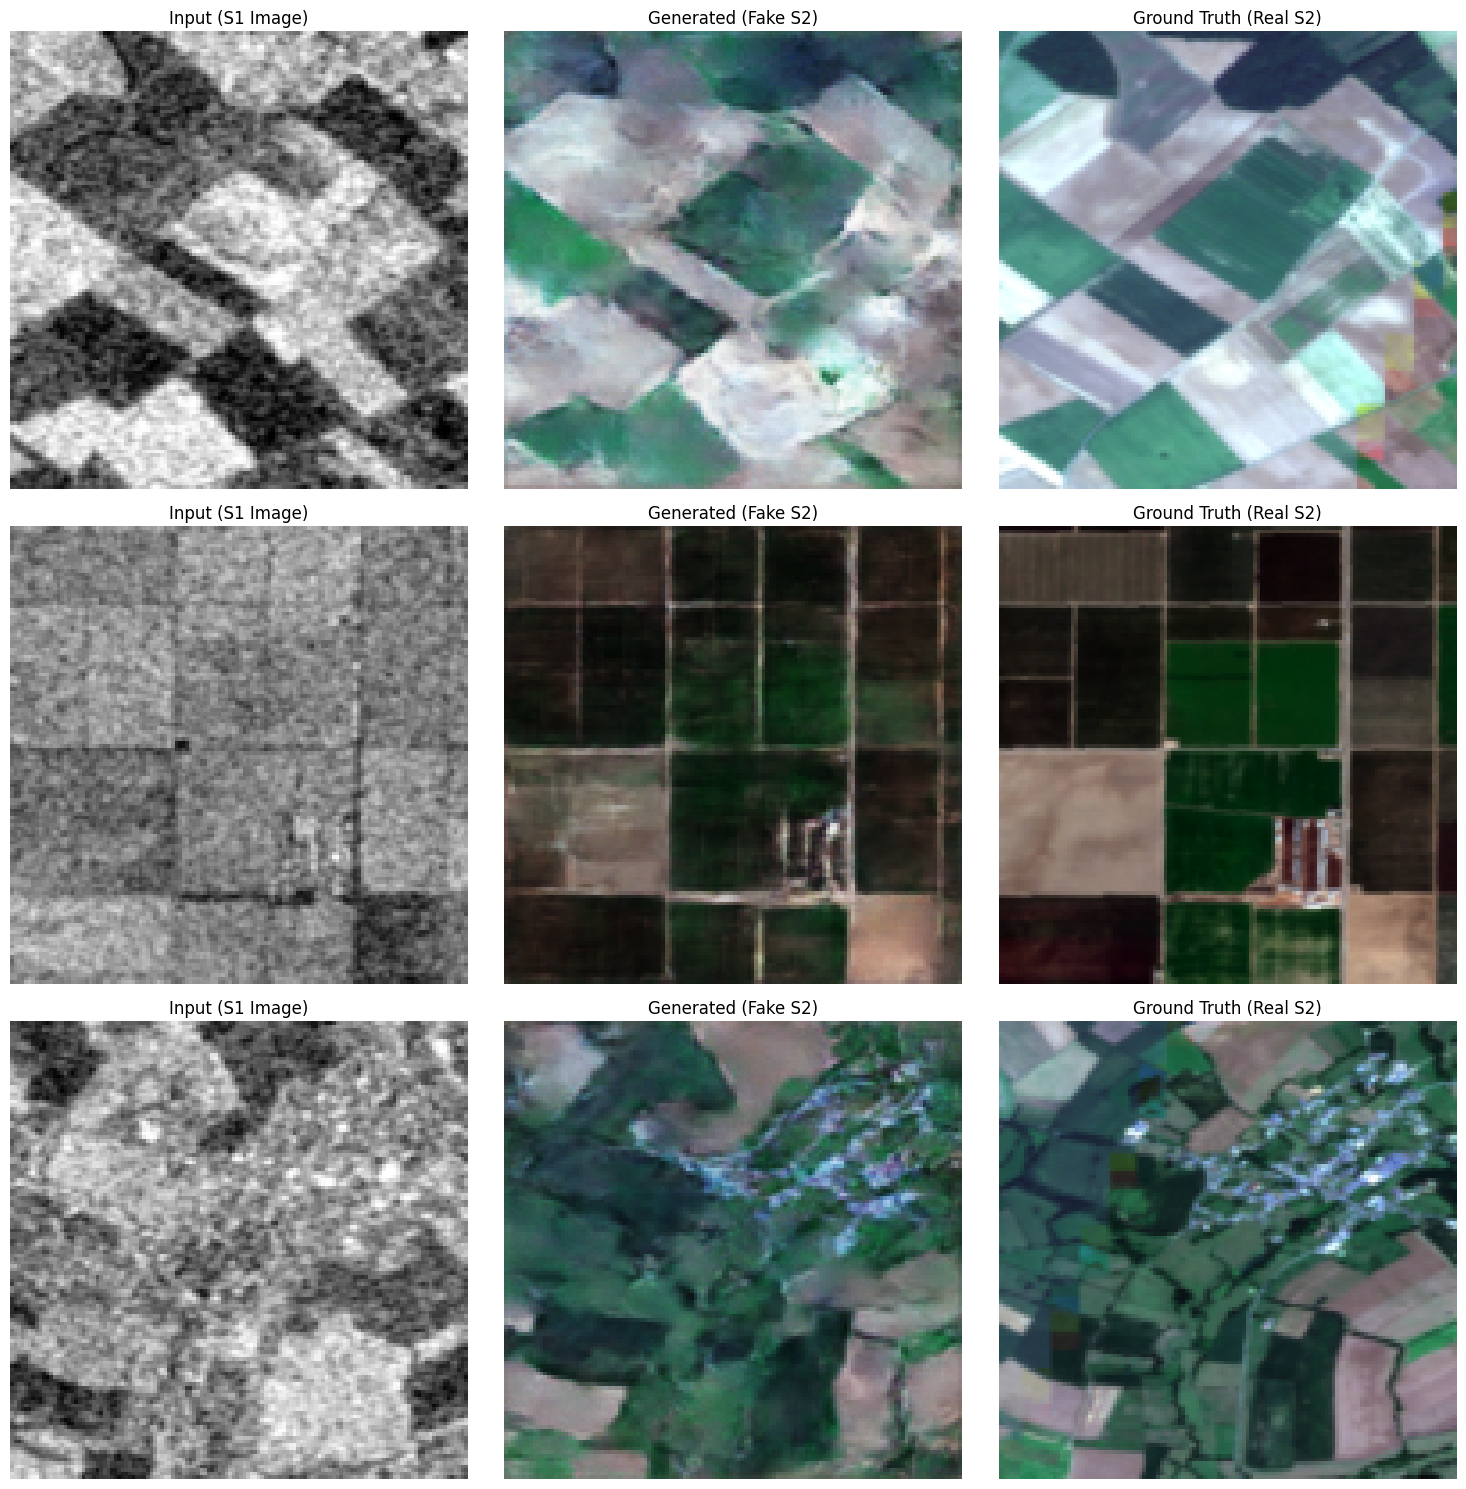

In [30]:
gen.eval()
try:
    val_iterator = iter(val_loader)
    x, y = next(val_iterator)
    x, y = x.to(device), y.to(device)

    with torch.no_grad():
        y_fake = gen(x)
        x = x * 0.5 + 0.5
        y = y * 0.5 + 0.5
        y_fake = y_fake * 0.5 + 0.5

    n_examples = 3
    plt.figure(figsize=(15, 15))

    for i in range(n_examples):
        plt.subplot(n_examples, 3, i*3 + 1)
        plt.imshow(x[i].cpu().permute(1, 2, 0))
        plt.title("Input (S1 Image)")
        plt.axis("off")

        plt.subplot(n_examples, 3, i*3 + 2)
        plt.imshow(y_fake[i].cpu().permute(1, 2, 0))
        plt.title("Generated (Fake S2)")
        plt.axis("off")

        plt.subplot(n_examples, 3, i*3 + 3)
        plt.imshow(y[i].cpu().permute(1, 2, 0))
        plt.title("Ground Truth (Real S2)")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

except StopIteration:
    print("DataLoader exhausted. Please re-run the training cell if you wish to see new results.")

In [31]:
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
from torchmetrics.image import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity

def evaluate_model(gen, loader, device):
    l1_loss_fn = nn.L1Loss()

    # Initialize metrics (FID has been removed)
    psnr = PeakSignalNoiseRatio(data_range=1.0).to(device)
    ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    lpips = LearnedPerceptualImagePatchSimilarity(net_type='alex').to(device)

    total_l1_loss = 0.0

    gen.eval()
    loop = tqdm(loader, leave=True, desc="Evaluating")

    with torch.no_grad():
        for x, y in loop:
            x, y = x.to(device), y.to(device)
            y_fake = gen(x)

            # De-normalize images from [-1, 1] to [0, 1]
            y_de = (y * 0.5 + 0.5)
            y_fake_de = (y_fake * 0.5 + 0.5)

            # Update metrics
            total_l1_loss += l1_loss_fn(y_fake_de, y_de).item()
            psnr.update(y_fake_de, y_de)
            ssim.update(y_fake_de, y_de)
            lpips.update(y_fake_de, y_de)

    # Compute final scores
    avg_l1 = total_l1_loss / len(loader)
    final_psnr = psnr.compute()
    final_ssim = ssim.compute()
    final_lpips = lpips.compute()

    gen.train()

    print("\n--- Evaluation Metrics ---")
    print(f"Average L1 Loss: {avg_l1:.4f} (Lower is better)")
    print(f"Average PSNR:    {final_psnr:.4f} (Higher is better)")
    print(f"Average SSIM:    {final_ssim:.4f} (Higher is better)")
    print(f"LPIPS:           {final_lpips:.4f} (Lower is better)")
    print("--------------------------")

    return {
        "L1": avg_l1,
        "PSNR": final_psnr.item(),
        "SSIM": final_ssim.item(),
        "LPIPS": final_lpips.item()
    }

In [32]:
evaluate_model(gen, val_loader, device)

Evaluating:   0%|          | 0/50 [00:00<?, ?it/s]


--- Evaluation Metrics ---
Average L1 Loss: 0.0775 (Lower is better)
Average PSNR:    19.0744 (Higher is better)
Average SSIM:    0.4785 (Higher is better)
LPIPS:           0.2227 (Lower is better)
--------------------------


{'L1': 0.07747994169592858,
 'PSNR': 19.074350357055664,
 'SSIM': 0.47845596075057983,
 'LPIPS': 0.2226901650428772}

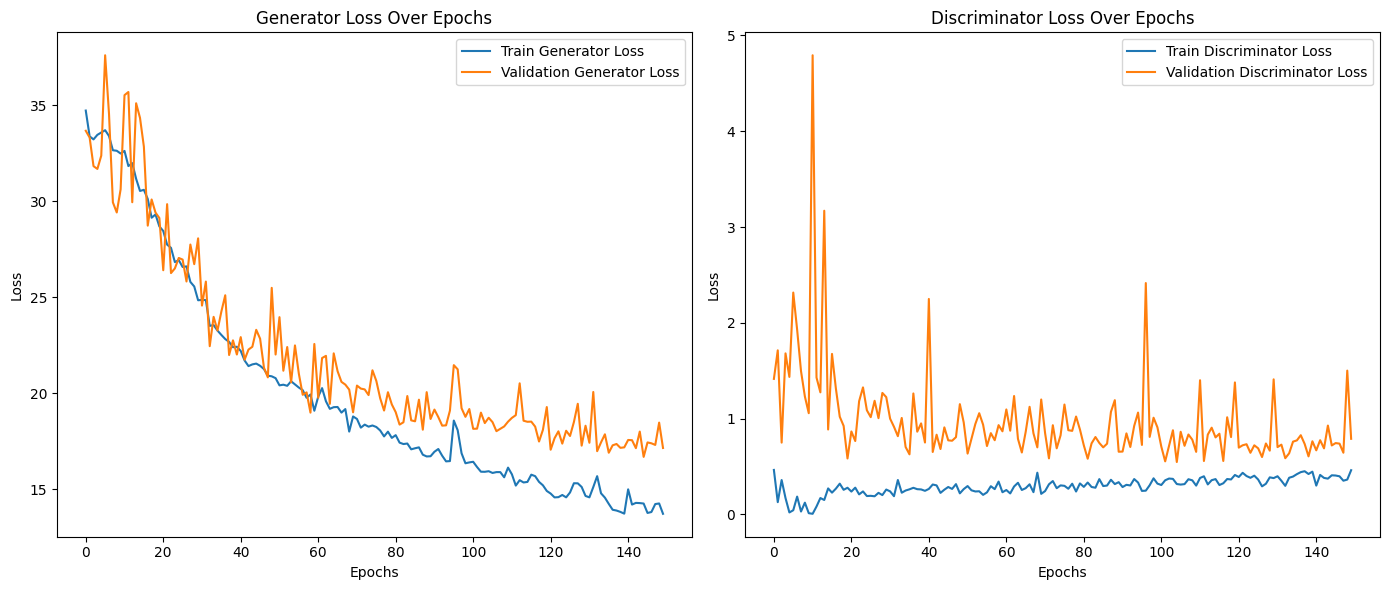

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Plot Generator Loss
plt.subplot(1, 2, 1)
plt.plot(g_loss_history, label='Train Generator Loss')
plt.plot(g_loss_val_history, label='Validation Generator Loss')
plt.title("Generator Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot Discriminator Loss
plt.subplot(1, 2, 2)
plt.plot(d_loss_history, label='Train Discriminator Loss')
plt.plot(d_loss_val_history, label='Validation Discriminator Loss')
plt.title("Discriminator Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

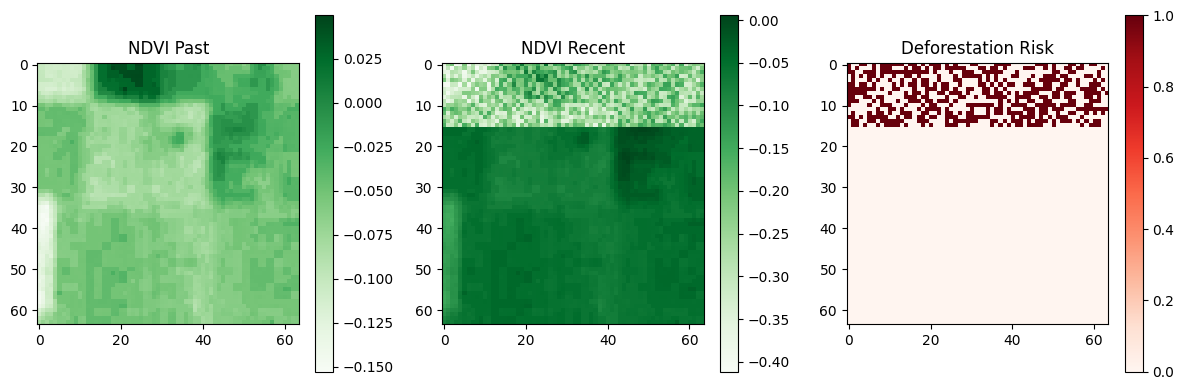

Deforestation detection performed using CSV NDVI data.


In [34]:
# Deforestation Detection Example using CSV NDVI Data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load NDVI data from CSV
csv_path = "ndvi_dataset.csv"  # Change path if needed
df = pd.read_csv(csv_path)

# Reshape NDVI arrays back to 2D
image_size = int(np.sqrt(len(df)))  # For our data, it's 64
ndvi_past = df["ndvi_past"].values.reshape((image_size, image_size))
ndvi_recent = df["ndvi_recent"].values.reshape((image_size, image_size))

# Calculate NDVI difference
diff = ndvi_recent - ndvi_past

# Threshold for significant vegetation loss
deforestation_mask = diff < -0.2

# Plot results
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.title('NDVI Past')
plt.imshow(ndvi_past, cmap='Greens')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title('NDVI Recent')
plt.imshow(ndvi_recent, cmap='Greens')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title('Deforestation Risk')
plt.imshow(deforestation_mask, cmap='Reds')
plt.colorbar()

plt.tight_layout()
plt.show()

print("Deforestation detection performed using CSV NDVI data.")


Using files: ROIs1868_summer_s2_59_p10.png and ROIs1868_summer_s2_59_p100.png to simulate different dates for demonstration.


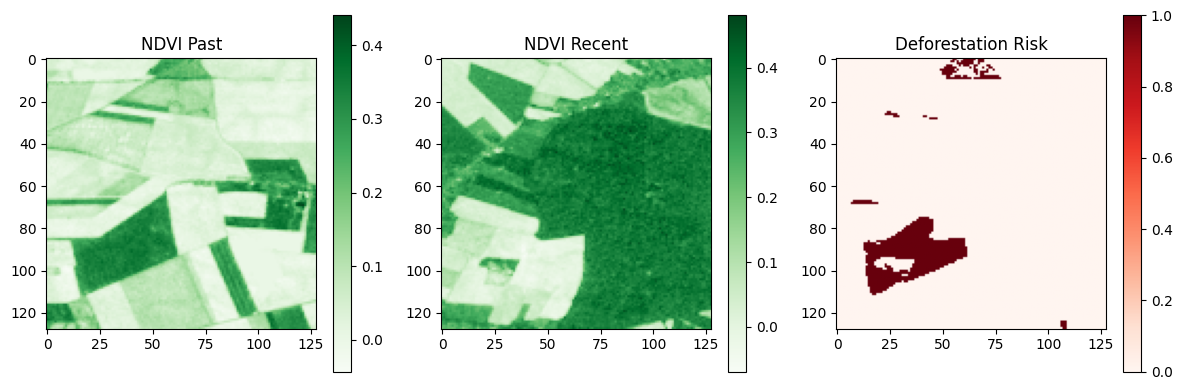

Simulated Deforestation Detection using ROIs1868_summer_s2_59_p10.png (Past) and ROIs1868_summer_s2_59_p100.png (Recent)
Red channel: 0, NIR channel: 2 (Adjust if your S2 data has a different channel order)


In [ ]:
# Automated Deforestation Detection from Sentinel-2 Images
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

def load_s2_image(path, image_size=128):
    img = Image.open(path).convert('RGB').resize((image_size, image_size))
    arr = np.asarray(img).astype(np.float32) / 255.0  # Normalize to [0,1]
    arr = arr.transpose(2, 0, 1)  # [C, H, W]
    return arr

def compute_ndvi(img, red_idx=0, nir_idx=2):
    """
    Compute NDVI from a 3-channel image.
    Adjust red_idx and nir_idx according to your channel order.
    """
    red = img[red_idx]
    nir = img[nir_idx]
    # Add a small epsilon to avoid division by zero and handle cases where nir + red is close to zero
    ndvi = (nir - red) / (nir + red + 1e-8)
    return ndvi

# Set your Sentinel-2 folder paths for two dates
# Assuming the dataset structure is path_to_dataset/v_2/terrain/s2
s2_dir_base = os.path.join(requiemonk_sentinel12_image_pairs_segregated_by_terrain_path, 'v_2', 'agri', 's2')

# In a real-world scenario, you would have S2 images from different dates.
# For this example, we'll use pairs from the same directory to demonstrate the NDVI calculation.
# Replace these with paths to S2 images from different dates if you have them.
# For demonstration, let's pick two arbitrary files from the s2 directory.
s2_files_in_dir = sorted([f for f in os.listdir(s2_dir_base) if f.endswith('.png')])

if len(s2_files_in_dir) < 2:
    print("Not enough Sentinel-2 images found in the directory to demonstrate deforestation detection.")
else:
    # Select two different files for demonstration (representing different dates)
    file1 = s2_files_in_dir[0]
    file2 = s2_files_in_dir[1]

    print(f"Using files: {file1} and {file2} to simulate different dates for demonstration.")

    s2_past_path = os.path.join(s2_dir_base, file1)
    s2_recent_path = os.path.join(s2_dir_base, file2)

    s2_past = load_s2_image(s2_past_path)
    s2_recent = load_s2_image(s2_recent_path)

    ndvi_past = compute_ndvi(s2_past)
    ndvi_recent = compute_ndvi(s2_recent)

    # Calculate NDVI difference
    diff = ndvi_recent - ndvi_past

    # Threshold for significant vegetation loss (you might need to adjust this)
    deforestation_mask = diff < -0.2

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title('NDVI Past')
    plt.imshow(ndvi_past, cmap='Greens')
    plt.colorbar()
    plt.subplot(1, 3, 2)
    plt.title('NDVI Recent')
    plt.imshow(ndvi_recent, cmap='Greens')
    plt.colorbar()
    plt.subplot(1, 3, 3)
    plt.title('Deforestation Risk')
    plt.imshow(deforestation_mask, cmap='Reds')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

    print(f"Simulated Deforestation Detection using {file1} (Past) and {file2} (Recent)")
    print("Red channel: 0, NIR channel: 2 (Adjust if your S2 data has a different channel order)")

## Implement workflow 1 (s1 to s2 generation and comparison)




--- Deforestation Detection using Synthetic Sentinel-2 from Sentinel-1 ---
Please enter the path to your past Sentinel-1 image: /content/WhatsApp Image 2025-08-19 at 10.23.17_15074646.jpg
Please enter the path to your recent Sentinel-1 image: /content/WhatsApp Image 2025-08-19 at 10.23.17_9cd55a00.jpg
Successfully generated synthetic Sentinel-2 images from Sentinel-1 images.
Successfully performed deforestation detection using synthetic S2 images.


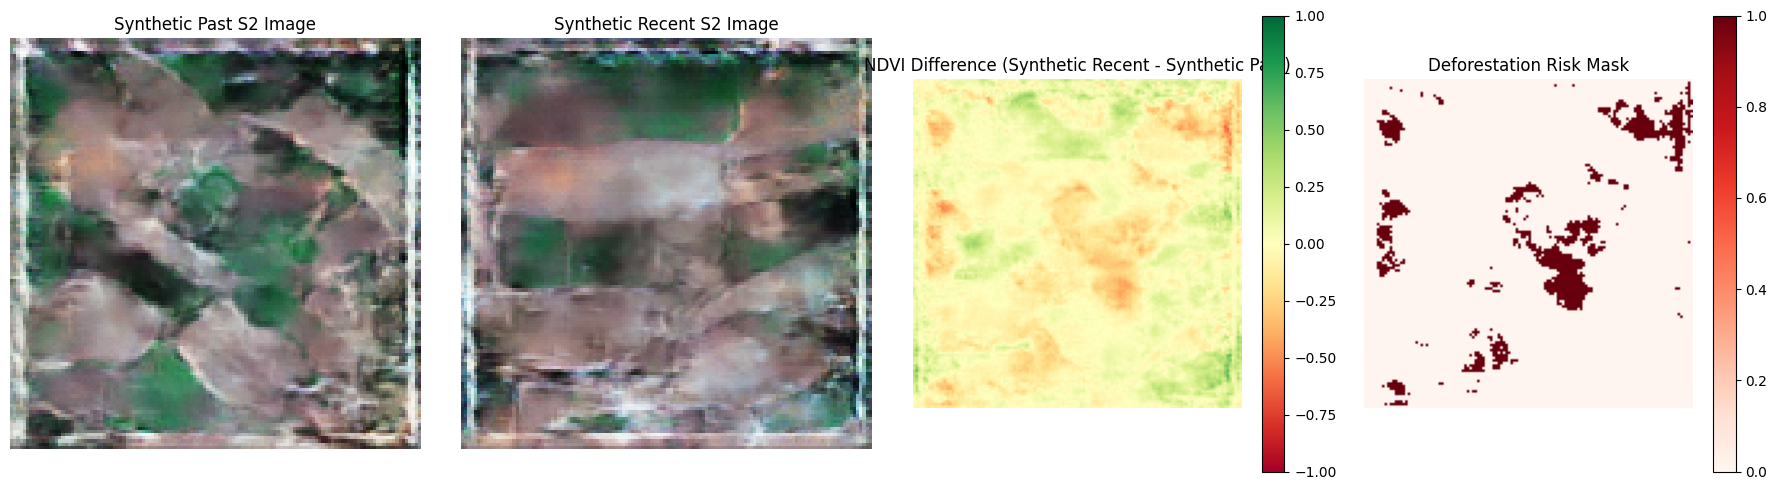

In [36]:
# Automated Deforestation Detection using Synthetic Sentinel-2 Images from Sentinel-1
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch

def load_s1_image(path, image_size=128):
    """
    Loads and preprocesses a Sentinel-1 image.
    Assuming S1 images are 3-channel RGB or can be adapted.
    Returns image in [C, H, W] format, normalized to [0, 1].
    """
    img = Image.open(path).convert('RGB').resize((image_size, image_size))
    arr = np.asarray(img).astype(np.float32) / 255.0  # Normalize to [0,1]
    arr = arr.transpose(2, 0, 1)  # [C, H, W]
    return arr

def compute_ndvi(img, red_idx=0, nir_idx=2):
    """
    Compute NDVI from a 3-channel image ([C, H, W]).
    Adjust red_idx and nir_idx according to your channel order.
    """
    red = img[red_idx]
    nir = img[nir_idx]
    # Add a small epsilon to avoid division by zero and handle cases where nir + red is close to zero
    ndvi = (nir - red) / (nir + red + 1e-8)
    return ndvi

print("\n--- Deforestation Detection using Synthetic Sentinel-2 from Sentinel-1 ---")

past_s1_image_path = input("Please enter the path to your past Sentinel-1 image: ")
recent_s1_image_path = input("Please enter the path to your recent Sentinel-1 image: ")

synthetic_s2_past_denorm = None
synthetic_s2_recent_denorm = None

try:
    # Load past Sentinel-1 image
    past_s1_image = load_s1_image(past_s1_image_path)
    past_s1_image_tensor = torch.from_numpy((past_s1_image - 0.5) / 0.5).unsqueeze(0).to(device) # Normalize to [-1, 1]

    # Load recent Sentinel-1 image
    recent_s1_image = load_s1_image(recent_s1_image_path)
    recent_s1_image_tensor = torch.from_numpy((recent_s1_image - 0.5) / 0.5).unsqueeze(0).to(device) # Normalize to [-1, 1]

    # Generate synthetic Sentinel-2 images
    gen.eval() # Set the generator to evaluation mode
    with torch.no_grad():
        synthetic_s2_past = gen(past_s1_image_tensor)
        synthetic_s2_recent = gen(recent_s1_image_tensor)

    # De-normalize and convert generated images
    synthetic_s2_past_denorm = (synthetic_s2_past * 0.5 + 0.5).squeeze(0).cpu().numpy() # [C, H, W], [0, 1]
    synthetic_s2_recent_denorm = (synthetic_s2_recent * 0.5 + 0.5).squeeze(0).cpu().numpy() # [C, H, W], [0, 1]


    print("Successfully generated synthetic Sentinel-2 images from Sentinel-1 images.")

    # Perform deforestation detection using synthetic S2 images
    if synthetic_s2_past_denorm is not None and synthetic_s2_recent_denorm is not None:
        try:
            # Compute NDVI for both synthetic images
            ndvi_past_synthetic = compute_ndvi(synthetic_s2_past_denorm)
            ndvi_recent_synthetic = compute_ndvi(synthetic_s2_recent_denorm)

            # Calculate NDVI difference
            diff = ndvi_recent_synthetic - ndvi_past_synthetic

            # Threshold for significant vegetation loss (you might need to adjust this)
            deforestation_mask = diff < -0.2

            print("Successfully performed deforestation detection using synthetic S2 images.")

            # Visualize the results
            plt.figure(figsize=(18, 5))

            plt.subplot(1, 4, 1)
            plt.title('Synthetic Past S2 Image')
            plt.imshow(synthetic_s2_past_denorm.transpose(1, 2, 0)) # Transpose back to [H, W, C] for plotting
            plt.axis("off")

            plt.subplot(1, 4, 2)
            plt.title('Synthetic Recent S2 Image')
            plt.imshow(synthetic_s2_recent_denorm.transpose(1, 2, 0)) # Transpose back to [H, W, C] for plotting
            plt.axis("off")

            plt.subplot(1, 4, 3)
            plt.title('NDVI Difference (Synthetic Recent - Synthetic Past)')
            plt.imshow(diff, cmap='RdYlGn', vmin=-1, vmax=1)
            plt.colorbar()
            plt.axis("off")

            plt.subplot(1, 4, 4)
            plt.title('Deforestation Risk Mask')
            plt.imshow(deforestation_mask, cmap='Reds')
            plt.colorbar()
            plt.axis("off")

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"An error occurred during deforestation detection or visualization: {e}")


except FileNotFoundError as e:
    print(f"Error: File not found - {e}. Please check the path(s) and try again.")
    synthetic_s2_past_denorm = None
    synthetic_s2_recent_denorm = None
except Exception as e:
    print(f"An error occurred during image processing: {e}")
    synthetic_s2_past_denorm = None
    synthetic_s2_recent_denorm = None
finally:
    gen.train() # Set the generator back to training mode

In [37]:
import torch

# Save Generator
torch.save(gen.state_dict(), "generator.pth")

# Save Discriminator
torch.save(disc.state_dict(), "discriminator.pth")

print("Models saved!")

Models saved!


In [38]:
from google.colab import files

files.download("generator.pth")
files.download("discriminator.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>